> **Introduction**

This problem is supervised text classification, our goal is to investigate which machine learning models are best suited to solve it.
Given a new poem we want to assign it to one of the four categories based on emotions.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualization
import matplotlib.pyplot as plt # graphs and plotting

# import various required models and modules from scikitlearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics



# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input/"))

# Any results you write to the current directory are saved as output.

['PERC_mendelly.xlsx']


In [2]:
# load data
df = pd.read_excel('../input/PERC_mendelly.xlsx')
df.head()

,Poem,Emotion
0,A Tree\nA tree beside the sandy river-beach \n...,sad
1,"Sri Krishna\n\nO immense Light and thou, O spi...",love
2,"Who\n\n\nIn the blue of the sky, in the green ...",peace
3,Revelation\n\n\nSomeone leaping from the rocks...,sad
4,The Silver Call\n\n\nThere is a godhead of unr...,joy


In [3]:
# extract content and type columns only
df = df.drop_duplicates()
df.describe(include='all')


,Poem,Emotion
count,713,713
unique,712,9
top,"Baby's Way \n\nIf baby only wanted to, he coul...",love
freq,2,161


In [4]:
# check for null values
df.isnull().any().describe()

count         2
unique        1
top       False
freq          2
dtype: object

In [5]:
# take a insight of data
df['Poem'][0]

'A Tree\nA tree beside the sandy river-beach \n    Holds up its topmost boughs \nLike fingers towards the skies they cannot reach, \n    Earth-bound, heaven amorous. \n\nThis is the soul of man. Body and brain \nHungry for earth our heavenly flight detain. \n\n'

In [6]:
# remove unneccesary new line characters and extra spaces

import re

poems = []
for poem in df.Poem:
    poem = poem.replace('\n',' ')
    poem = poem.replace('\n\n',' ')
    poem = poem.replace('\n\'',' ')
    poem = poem.replace('\'','')
    poem = re.sub(' +',' ',poem)
    poems.append(poem)
df["Poem"] = poems
df.head()

,Poem,Emotion
0,A Tree A tree beside the sandy river-beach Hol...,sad
1,"Sri Krishna O immense Light and thou, O spirit...",love
2,"Who In the blue of the sky, in the green of th...",peace
3,Revelation Someone leaping from the rocks Past...,sad
4,The Silver Call There is a godhead of unrealis...,joy


In [7]:
#data after preprocessing
df.Poem[0]

'A Tree A tree beside the sandy river-beach Holds up its topmost boughs Like fingers towards the skies they cannot reach, Earth-bound, heaven amorous. This is the soul of man. Body and brain Hungry for earth our heavenly flight detain. '

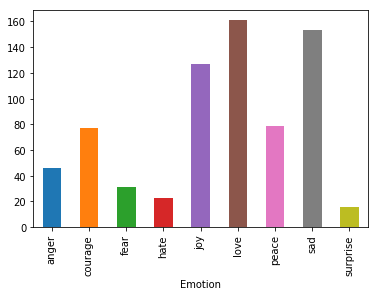

In [8]:

df.groupby('Emotion').Emotion.count().plot.bar()
plt.show()

In [9]:
# extract top 4 most contrasting emotion categories
df = df.loc[df.Emotion.isin(['anger','love','joy','courage'])]
df.groupby('Emotion').Poem.count()

Emotion
anger       46
courage     77
joy        127
love       161
Name: Poem, dtype: int64

In [10]:
# assign an unique integer category to each emotion category 
df['category_id'] = df['Emotion'].factorize()[0]
emotion_id_df = df[['Emotion','category_id']].drop_duplicates().sort_values('category_id')
emotion_to_id = dict(emotion_id_df.values)
id_to_emotion = dict(emotion_id_df[['category_id','Emotion']].values)
df.head()    

,Poem,Emotion,category_id
1,"Sri Krishna O immense Light and thou, O spirit...",love,0
4,The Silver Call There is a godhead of unrealis...,joy,1
5,"Surrender O THOU of whom I am the instrument, ...",love,0
6,Krishna At last I find a meaning of souls birt...,joy,1
8,"Bride of the Fire Bride of the Fire, clasp me ...",love,0


In [11]:
# extract tf-idf features from the data
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1',
                     ngram_range = (1,2), stop_words='english')
features = tfidf.fit_transform(df.Poem).toarray()
labels = df.category_id
features.shape

(411, 1153)

In [12]:
# find most corelated terms to each category
N = 3
for typ, category_id in sorted(emotion_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print('# {}:'.format(typ))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))



# anger:
  . Most correlated unigrams:
. daddy
. dad
. anger
  . Most correlated bigrams:
. control anger
. anger turns
. anger anger
# courage:
  . Most correlated unigrams:
. goals
. believe
. courage
  . Most correlated bigrams:
. dreams come
. stand tall
. come true
# joy:
  . Most correlated unigrams:
. leaf
. love
. laughter
  . Most correlated bigrams:
. come true
. love love
. laughter laughter
# love:
  . Most correlated unigrams:
. anger
. thy
. love
  . Most correlated bigrams:
. lovers gifts
. touch hand
. love love


> **Model 1 : Naive Bayes Classifier** 

In [13]:
# split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state = 7,
                                                    test_size = 0.2)


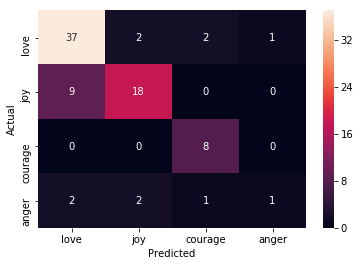

In [14]:
# fit the training data into a multinomial naive bayes classifier
model1 = MultinomialNB(alpha=0.5)

model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)

# cofusion matrix
conf_mat = confusion_matrix(y_test, y_pred1)
sns.heatmap(conf_mat, xticklabels=emotion_id_df.Emotion.values, 
            yticklabels=emotion_id_df.Emotion.values,annot = True)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [15]:
#training accuracy of classifier 1
model1.score(X_train,y_train)

0.9298780487804879

In [16]:
#test accuracy of classifier 1
model1.score(X_test,y_test)

0.7710843373493976

In [17]:
# final evlauation of classifier 1
print(metrics.classification_report(y_test, y_pred1, 
                                    target_names=df['Emotion'].unique()))


              precision    recall  f1-score   support

        love       0.77      0.88      0.82        42
         joy       0.82      0.67      0.73        27
     courage       0.73      1.00      0.84         8
       anger       0.50      0.17      0.25         6

   micro avg       0.77      0.77      0.77        83
   macro avg       0.70      0.68      0.66        83
weighted avg       0.76      0.77      0.75        83



> **Model 2 : Liner Support Vector Classifier**

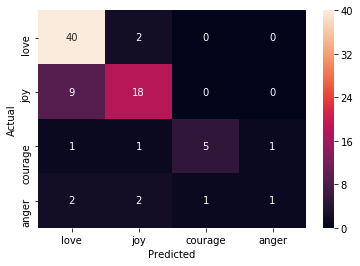

In [18]:
# fit the training data into a linear support vector classifier
model2 = LinearSVC(C = 0.1)

model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)

# confusion matrix for model 2
conf_mat = confusion_matrix(y_test, y_pred2)
sns.heatmap(conf_mat, xticklabels=emotion_id_df.Emotion.values, 
            yticklabels=emotion_id_df.Emotion.values,annot = True)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [19]:
# training accuracy of classifier 2
model2.score(X_train, y_train)

0.8963414634146342

In [20]:
# test accuracy of classifier 2
model2.score(X_test, y_test)

0.7710843373493976

In [21]:
# final evaluation of classifier 2
print(metrics.classification_report(y_test, y_pred2, 
                                    target_names=df['Emotion'].unique()))


              precision    recall  f1-score   support

        love       0.77      0.95      0.85        42
         joy       0.78      0.67      0.72        27
     courage       0.83      0.62      0.71         8
       anger       0.50      0.17      0.25         6

   micro avg       0.77      0.77      0.77        83
   macro avg       0.72      0.60      0.63        83
weighted avg       0.76      0.77      0.75        83



*Notebook written by:*
Inderjeet Singh
inderjeetsingh9646@gmail.com

*Data source:*
https://data.mendeley.com/datasets/n9vbc8g9cx/1
